# Mutual information

This notebook compute the mutual information between two paired TCR sequences $(\alpha, \beta)$, $(\alpha, \alpha)$ and $(\beta, \beta)$ (generating Fig. 2.). It also simulates a modification of the mutual information as a function of the "selection level".

In [1]:
from __future__ import division, print_function
from IPython.display import display, HTML
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import ticker
from IPython.display import display, Math, Latex
from math import log, sqrt
import editdistance
import pickle
from scipy.special import xlogy

In [2]:
# Experiment selection : 
exp="exp3"

filepairsab = "../Datas/"+exp+"/pairs_ab.tsv.gz"
filepairsaa = "../Datas/"+exp+"/pairs_aa.tsv.gz"
filepairsbb = "../Datas/"+exp+"/pairs_bb.tsv.gz"


def H(prob):
    return -sum(prob.apply(lambda x: x*log(x,2)))

def mutual_information(df, keys1, keys2=None, return_dict=False):
    """ Return a numerical array containing the mutual 
        informations between the different keys.
    """
    
    if keys2 is None:
        keys = keys1
        keys2 = keys1
    else:
        keys = keys1 + keys2
    p = {k: (df[k].value_counts())/len(df) for k in keys}
    p2 = {(k,l):(df.groupby([k, l]).size())/len(df) for k in keys1 for l in keys2}
    I = {(k,l): -H(p2[k,l]) + H(p[k]) + H(p[l]) for k in keys1 for l in keys2}

    
    # Correct the mutual information bias for small sizes
    corr_I = {(k,l): 
              (len(df[k].value_counts())*len(df[l].value_counts()) -
                     len(df[k].value_counts()) -len(df[l].value_counts()) +
                     1)/(2*df.size*log(2))
              for k in keys1 for l in keys2}
    nI = {(k,l): (- H(p2[k,l]) + H(p[k]) + H(p[l]) - corr_I[k,l]
                 ) for k in keys1 for l in keys2}
    if(return_dict):
        return nI
    Is = np.zeros((len(keys1), len(keys2)))
    for k in range(len(keys1)):
        for l in range(len(keys2)):
            Is[k, l] = (nI[keys1[k], keys2[l]] if l!=k else 0)
            #print(keys[k], keys[l], Is[k,l])
    return Is

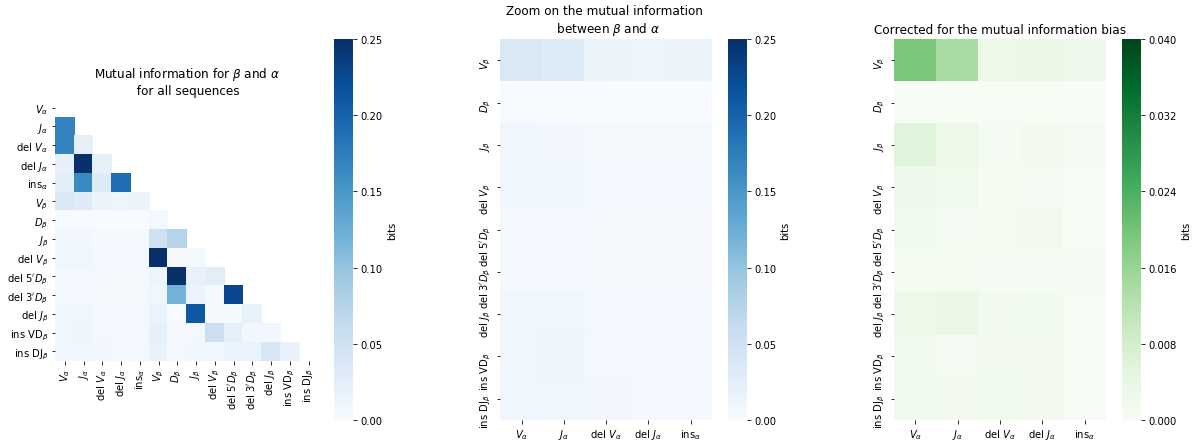

In [3]:
df = pd.read_csv(filepairsab, sep='\t')

keys = ['vname_1', 'jname_1', 'vdel_1', 'jdel_1', 'n1ins_1', 'vname_2', 'dname_2',
        'jname_2', 'vdel_2', 'd5del_2', 'd3del_2', 'jdel_2', 'n2ins_2', 'n1ins_2']
dfshuffled = df[keys].copy()
df = df[keys].copy()

df_alpha = df[['vname_1', 'jname_1', 'vdel_1', 'jdel_1', 'n1ins_1']].copy()
df_beta = df[['vname_2', 'dname_2','jname_2', 'vdel_2',
              'd5del_2', 'd3del_2', 'jdel_2', 'n2ins_2', 'n1ins_2']].copy()
df_beta = df_beta.sample(frac=1).reset_index(drop=True)
df_shuffled = pd.concat([df_alpha, df_beta], axis=1)


df = df.dropna()
df_shuffled = df_shuffled.dropna()

Is = mutual_information(df, keys)
Is_shuffled = mutual_information(df_shuffled, keys)


indx = [r'$V_\alpha$', r'$J_\alpha$', r'$\mathrm{del}\ V_\alpha$', r'$\mathrm{del}\ J_\alpha$',
        r'$\mathrm{ins}_\alpha$', r'$V_\beta$',r'$D_\beta$', r'$J_\beta$', r'$\mathrm{del}\ V_\beta$',
        r'$\mathrm{del}\ 5^\prime D_\beta$', r'$\mathrm{del}\ 3^\prime D_\beta$', r'$\mathrm{del}\ J_\beta$',
        r'$\mathrm{ins\ VD}_\beta$', r'$\mathrm{ins\ DJ}_\beta$']

u_corrected = pd.DataFrame(Is - Is_shuffled, index=indx, columns=indx)
u_corrected_zoom = pd.DataFrame(Is[5:, :5] - Is_shuffled[5:, :5], index=indx[5:], columns=indx[:5])
u = pd.DataFrame(Is, index=indx, columns=indx)
u_zoom = pd.DataFrame(Is[5:, :5], index=indx[5:], columns=indx[:5])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 7))

mask=np.zeros_like(u)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(u, vmin=0., vmax=0.25, mask=mask, cmap="Blues", square=True, ax=ax1, cbar_kws={'label': 'bits'})
ax1.set_title("Mutual information for $\\beta$ and $\\alpha$ \n for all sequences")
sns.heatmap(u_zoom, vmin=0., vmax=0.25, cmap="Blues", square=True, ax=ax2, cbar_kws={'label': 'bits'})
ax2.set_title("Zoom on the mutual information \n between $\\beta$ and $\\alpha$")
sns.heatmap(u_corrected_zoom, vmin=0., vmax=0.04, cmap="Greens", square=True, ax=ax3, cbar_kws={'label': 'bits'})
ax3.set_title("Corrected for the mutual information bias")

plt.savefig("mutual_information_ab.pdf")

plt.show()

## Mutual information between pairs $(\alpha-\alpha)$ and $(\beta-\beta)$

The distance distribution allows to choose a threshold to discriminate between real and fake pairings.

/home/tautilde/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


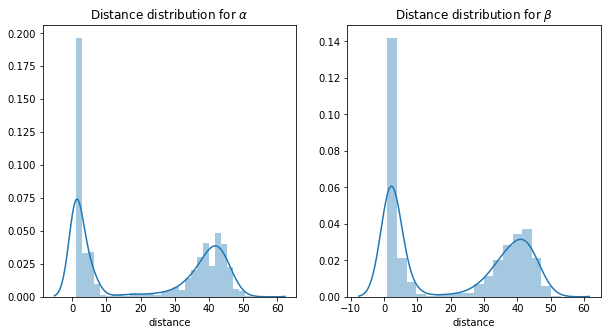

In [4]:
dfbb = pd.read_csv(filepairsbb, sep='\t')
dfaa = pd.read_csv(filepairsaa, sep='\t')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
sns.distplot(dfaa.distance, ax=ax1)
ax1.set_title(r"Distance distribution for $\alpha$")
sns.distplot(dfbb.distance, ax=ax2)
ax2.set_title(r"Distance distribution for $\beta$")


dfbb = dfbb[dfbb.distance > 16]
dfaa = dfaa[dfaa.distance > 16]


plt.show()

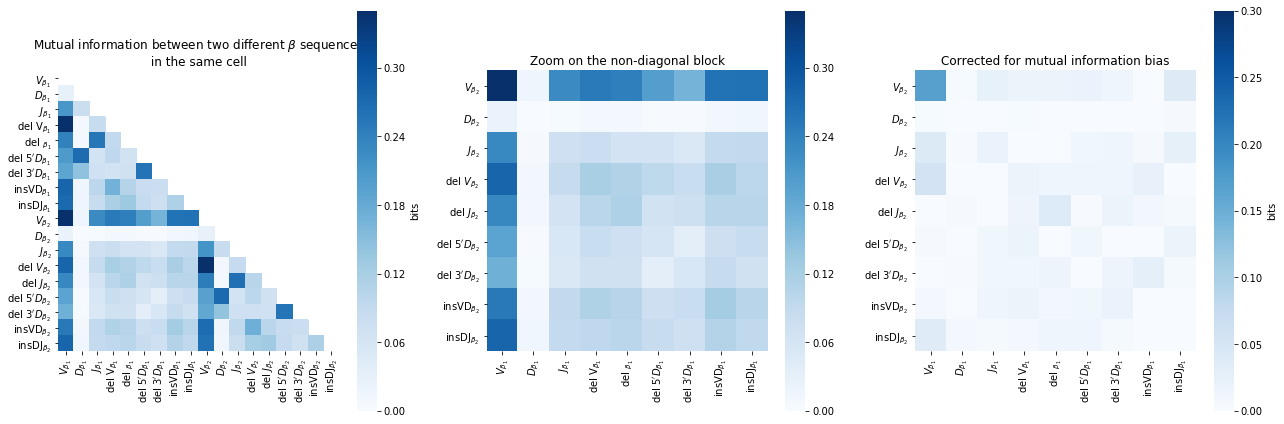

In [5]:
base_keys =  ['vname', 'dname', 'jname', 'vdel',
         'jdel','d5del','d3del', 'n2ins', 'n1ins']
keys_1 = [u + "_1" for u in base_keys]
keys_2 = [u + "_2" for u in base_keys]
keys = keys_1 + keys_2
# drop sequences for which VDJ couldn't be inferred
dfbb = dfbb.dropna()

dfbb.reset_index(drop=True)

df_beta_1 = dfbb[keys_1].copy().reset_index(drop=True)
df_beta_2 = dfbb[keys_2].copy().reset_index(drop=True)

df_beta_2 = df_beta_2.sample(frac=1).reset_index(drop=True) #shuffle
df_shuffled = pd.concat([df_beta_1, df_beta_2], axis=1)

Is = mutual_information(dfbb, keys)
Is_shuffled = mutual_information(df_shuffled, keys)
  
indx = [r'$V_{\beta_1}$',r'$D_{\beta_1}$', r'$J_{\beta_1}$', r'$\mathrm{del\ V}_{\beta_1}$', r'$\mathrm{del\ }_{\beta_1}$', 
         r'$\mathrm{del\ }5^\prime D_{\beta_1}$', r'$\mathrm{del\ }3^\prime D_{\beta_1}$', r'$\mathrm{ins VD}_{\beta_1}$',
        r'$\mathrm{ins DJ}_{\beta_1}$', r'$V_{\beta_2}$',r'$D_{\beta_2}$', r'$J_{\beta_2}$', r'$\mathrm{del}\ V_{\beta_2}$',
         r'$\mathrm{del}\ J_{\beta_2}$', r'$\mathrm{del}\ 5^\prime D_{\beta_2}$', r'$\mathrm{del}\ 3^\prime D_{\beta_2}$', 
         r'$\mathrm{ins VD}_{\beta_2}$', r'$\mathrm{ins DJ}_{\beta_2}$']

u = pd.DataFrame(Is, index=indx, columns=indx)
u_corrected_zoom = pd.DataFrame(Is[9:, :9]- Is_shuffled[9:, :9], index=indx[9:], columns=indx[:9])
u_zoom = pd.DataFrame(Is[9:,:9], index=indx[9:], columns=indx[:9])

mask=np.zeros_like(u)
mask[np.triu_indices_from(mask, 0)] = True

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
sns.heatmap(u, vmin=0., vmax=0.35, mask=mask, ax=ax1, cmap="Blues", square=True, cbar_kws={'label': 'bits'})
ax1.set_title("Mutual information between two different $\\beta$ sequences \n in the same cell ")
sns.heatmap(u_zoom, vmin=0., vmax=0.35, ax=ax2, cmap="Blues", square=True)
ax2.set_title(r"Zoom on the non-diagonal block")
sns.heatmap(u_corrected_zoom, vmin=0., vmax=0.30, ax=ax3, cmap="Blues", square=True, cbar_kws={'label': 'bits'})
ax3.set_title(r"Corrected for mutual information bias")

plt.tight_layout()
plt.savefig("mutual_information_bb.pdf")


plt.show()

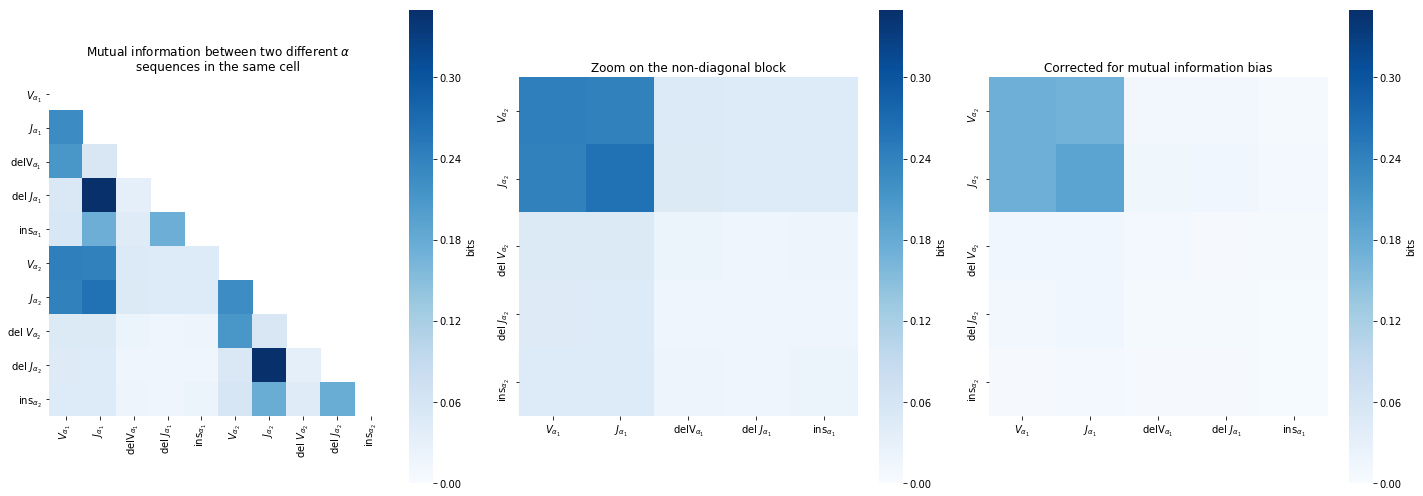

In [6]:
keys = ['vname', 'jname', 'vdel', 'jdel', 'n1ins']
keys_1 = [u+"_1" for u in keys]
keys_2 = [u+"_2" for u in keys]
keys = keys_1 + keys_2

dfaa.reset_index(drop=True)

df_alpha_1 = dfaa[keys_1].copy().reset_index(drop=True)
df_alpha_2 = dfaa[keys_2].copy().reset_index(drop=True)

df_alpha_2 = df_alpha_2.sample(frac=1).reset_index(drop=True) #shuffle
df_shuffled = pd.concat([df_alpha_1, df_alpha_2], axis=1)


Is = mutual_information(dfaa, keys)
Is_shuffled = mutual_information(df_shuffled, keys)

indx = [r'$V_{\alpha_1}$', r'$J_{\alpha_1}$', r'$\mathrm{del V}_{\alpha_1}$',
         r'$\mathrm{del}\ J_{\alpha_1}$', r'$\mathrm{ins}_{\alpha_1}$',
       r'$V_{\alpha_2}$',
        r'$J_{\alpha_2}$', r'$\mathrm{del}\ V_{\alpha_2}$', r'$\mathrm{del}\ J_{\alpha_2}$', r'$\mathrm{ins}_{\alpha_2}$']
u = pd.DataFrame(Is, index=indx, columns=indx)
u_corrected_zoom = pd.DataFrame(Is[5:, :5]  - Is_shuffled[5:, :5], index=indx[5:], columns=indx[:5])
u_zoom = pd.DataFrame(Is[5:, :5], index=indx[5:], columns=indx[:5])


mask=np.zeros_like(u)
mask[np.triu_indices_from(mask, 0)] = True

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 7))
sns.heatmap(u, vmin=0., vmax=0.35, mask=mask, ax=ax1, cmap="Blues", square=True,cbar_kws={'label': 'bits'})
for tick in ax1.get_xticklabels():
    tick.set_rotation(90)
ax1.set_title("Mutual information between two different $\\alpha$ \n sequences in the same cell ")
sns.heatmap(u_zoom, vmin=0., vmax=0.35, ax=ax2, cmap="Blues", square=True, cbar_kws={'label': 'bits'})
ax2.set_title(r"Zoom on the non-diagonal block")
sns.heatmap(u_corrected_zoom, vmin=0., vmax=0.35, ax=ax3, cmap="Blues", square=True, cbar_kws={'label': 'bits'})
ax3.set_title(r"Corrected for mutual information bias")

plt.tight_layout()
plt.savefig("mutual_information_aa.pdf")

plt.show()

## Selection model $V_A$, $V_B$, $J_A$

The aim of this section is to infer a "minimal selection model", which only assume that the selection process involve $V_A, V_B$ and $J_A$. We infer a selection factor from the data:

$$
q_{V_A, J_A, V_B} = \frac{P_{\text{exp}}(V_A, J_A, V_B)}{P(V_A, J_A) P(V_B)}
$$

From this experimental selection factor, we can create a probability model with an adjustable selection level:

$$
P^{T}(V_A, V_B, J_A) \propto \left(q_{V_A, V_B} q_{J_A, V_B}\right)^{T^{-1}} P(V_A, J_A) P(V_B)
$$

Where $T$ is a temperature. There is no selection at $T = \infty$, and $T = 0$ means that only the most common pairs of sequences $(V_A, V_B)$ are selected (maximal selection).

Note that this transformation does not conserve the marginal distribution $p(V_A)$ and $p(V_B)$.
This creates a selection model with a tunable parameter. We can then generate sequences using IGoR and pair them according to the selection factor $q^{T^{-1}}$.

In [7]:
## mutual information
def mutual_inf_np(a):
    a0 = np.sum(a, axis=0)
    a1 = np.sum(a, axis=1)
    return (np.sum(xlogy(a, a)) - np.sum(xlogy(a0, a0)) - np.sum(xlogy(a1, a1)))/np.log(2)



## generate the pickle files, necessit to have run the full 
## code, not needed if they are already defined

if False:
    filea = "../Datas/exp3/sequences_alpha.tsv.gz"
    fileb = "../Datas/exp3/sequences_beta.tsv.gz"

    dfa = pd.read_csv(filea, sep="\t", nrows=1000000)
    dfb = pd.read_csv(fileb, sep="\t", nrows=1000000)
    df_pairs = pd.read_csv(filepairsab, sep="\t")
    df_pairs = df_pairs[["vname_1", "jname_1","vname_2", "jname_2"]].dropna()
    dfa = dfa[["vname", "jname"]].copy().dropna()
    dfb = dfb[["vname", "jname"]].copy().dropna()

    pas = (dfa.groupby(["vname", "jname"]).size()/len(dfa)).to_dict()
    pbs = (dfb.groupby(["vname", "jname"]).size()/len(dfb)).to_dict()
    p_VaVb = (df_pairs.groupby(["vname_1", "vname_2"]).size()/len(df_pairs)).to_dict()
    p_VaJb = (df_pairs.groupby(["vname_1", "jname_2"]).size()/len(df_pairs)).to_dict()
    p_JaVb = (df_pairs.groupby(["jname_1", "vname_2"]).size()/len(df_pairs)).to_dict()
    p_JaJb = (df_pairs.groupby(["jname_1", "jname_2"]).size()/len(df_pairs)).to_dict()
    p_JaVaVb = (df_pairs.groupby(["jname_1", "vname_1", "vname_2"]).size()/len(df_pairs)).to_dict()


    with open("../Datas/mutual_information/proba_A.pkl", "wb") as f:
        pickle.dump(pas, f)
    with open("../Datas/mutual_information/proba_B.pkl", "wb") as f:
        pickle.dump(pbs, f)
    with open("../Datas/mutual_information/proba_VAVB.pkl", "wb") as f:
        pickle.dump(p_VaVb, f)
    with open("../Datas/mutual_information/proba_VAJB.pkl", "wb") as f:
        pickle.dump(p_VaJb, f)
    with open("../Datas/mutual_information/proba_JAVB.pkl", "wb") as f:
        pickle.dump(p_JaVb, f)
    with open("../Datas/mutual_information/proba_JAJB.pkl", "wb") as f:
        pickle.dump(p_JaJb, f)
    with open("../Datas/mutual_information/proba_JAVAVB.pkl", "wb") as f:
        pickle.dump(p_JaVaVb, f)


In [11]:
## load probability distributions
pas = pickle.load(open("../Datas/mutual_information/proba_A.pkl", "rb"))
pbs = pickle.load(open("../Datas/mutual_information/proba_B.pkl", "rb"))
pVaVb = pickle.load(open("../Datas/mutual_information/proba_VAVB.pkl", "rb"))
pVaJb = pickle.load(open("../Datas/mutual_information/proba_VAJB.pkl", "rb"))
pJaVb = pickle.load(open("../Datas/mutual_information/proba_JAVB.pkl", "rb"))
pJaJb = pickle.load(open("../Datas/mutual_information/proba_JAJB.pkl", "rb"))
pJaVaVb = pickle.load(open("../Datas/mutual_information/proba_JAVAVB.pkl", "rb"))

## load V genes
Va_names = set([u[0] for u in pas])
Vb_names = set([u[0] for u in pbs])
Ja_names = set([u[1] for u in pas])
Jb_names = set([u[1] for u in pbs])

# print(len(Jb_names), len(Vb_names), len(Va_names), len(Ja_names))


## Put everything in np.array form
pVbVa = np.array([[pVaVb[(va, vb)] if (va, vb) in pVaVb else 0. for va in Va_names] for vb in Vb_names])
pJbVa = np.array([[pVaJb[(va, jb)] if (va, jb) in pVaJb else 0. for va in Va_names] for jb in Jb_names])
pVbJa = np.array([[pJaVb[(ja, vb)] if (ja, vb) in pJaVb else 0. for ja in Ja_names] for vb in Vb_names])
pVbVaJa = np.array([[[pJaVaVb[(ja, va, vb)] if (ja, va, vb) in pJaVaVb else 0.
                     for ja in Ja_names] for va in Va_names] for vb in Vb_names])

pVbVaJa = pVbVaJa/np.sum(pVbVaJa)
pVbVa = pVbVa/np.sum(pVbVa)
pJbVa = pJbVa/np.sum(pJbVa)
pVbJa = pVbJa/np.sum(pVbJa)

pA = np.array([[pas[(va, ja)] if (va, ja) in pas else 0. for va in Va_names] for ja in Ja_names]).transpose()
pB = np.array([[pbs[(vb, jb)] if (vb, jb) in pbs else 0. for vb in Vb_names] for jb in Jb_names])
pVa = np.sum(pA, axis=1)
pVb = np.sum(pB, axis=0)
pJa = np.sum(pA, axis=0)
pJb = np.sum(pB, axis=1)

## q definitions 
qVbVaJa = pVbVaJa/(np.tensordot(pVb, pA, 0) + np.full(np.shape(pVbVaJa), 1e-10)) # not enough stats ?
qVbVa = pVbVa/np.tensordot(pVb, pVa, 0)
qVbJa = pVbJa/np.tensordot(pVb, pJa, 0)


qVbVa = np.tile(qVbVa, (len(Ja_names), 1, 1)).transpose((1, 2, 0))
qVbVa = np.tile(qVbVa, (len(Jb_names),1, 1, 1))



qVbJa = np.tile(qVbJa, (len(Va_names), 1, 1)).transpose((1, 0, 2))
qVbJa = np.tile(qVbJa, (len(Jb_names), 1, 1, 1))

qVbVaJa = np.tile(qVbVaJa, (len(Jb_names), 1, 1, 1))

pA = np.tile(np.tile(pA, (len(Vb_names),1,1)), (len(Jb_names),1,1,1))
pB = np.tile(pB, (len(Va_names),1,1)).transpose((1, 2,0))
pB = np.tile(pB, (len(Ja_names), 1, 1, 1)).transpose((1,2,3,0))

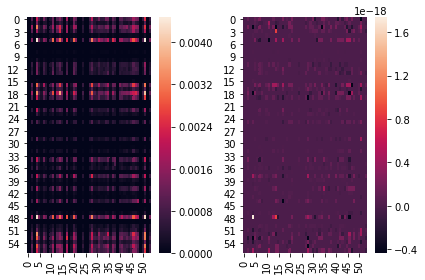

0.03774294209145133 0.03536352509471749


In [12]:
ptest = np.sum(qVbVa*qVbJa*pA*pB, axis=(0, 3))/np.sum(qVbVa*qVbJa*pA*pB)
ptest2 = np.sum(qVbVaJa*pA*pB, axis=(0, 3))/np.sum(qVbVaJa*pA*pB)
fig, (ax1, ax2) = plt.subplots(1, 2)
sns.heatmap(ptest2, ax=ax1)
sns.heatmap(np.sum(pVbVaJa, axis=2) - pVbVa, ax=ax2)
plt.tight_layout()
plt.show()
print(mutual_inf_np(ptest), mutual_inf_np(pVbVa/np.sum(pVbVa)))

In [13]:
## Compute the mutual information for various values of p 
## Relatively slow

mut_inf_VaVb = []
mut_inf_VaJb = []
mut_inf_VaJa = []
mut_inf_JaVb = []
for T in np.arange(0.4, 10, 0.02):
    p = np.power(qVbVaJa, 1./T)*pA*pB
    p = p/np.sum(p)
    mut_inf_VaVb.append(mutual_inf_np(np.sum(p, (0, 3))))
    mut_inf_VaJb.append(mutual_inf_np(np.sum(p, (1, 3))))
    mut_inf_VaJa.append(mutual_inf_np(np.sum(p, (0, 1))))
    mut_inf_JaVb.append(mutual_inf_np(np.sum(p, (0, 2))))

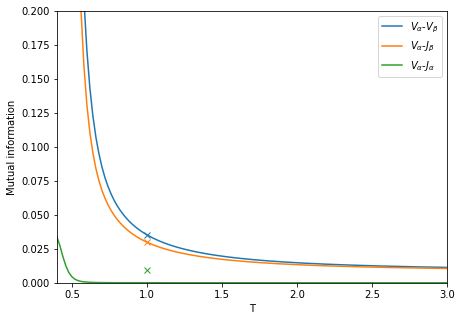

In [14]:
fig, ax = plt.subplots(1,1, figsize=(7,5))
ax.plot(np.arange(0.4, 10, 0.02), mut_inf_VaVb, label=r"$V_\alpha$-$V_\beta$")
ax.plot(np.arange(0.4, 10, 0.02), mut_inf_JaVb, label=r"$V_\alpha$-$J_\beta$")
ax.plot(np.arange(0.4, 10, 0.02), mut_inf_VaJb, label=r"$V_\alpha$-$J_\alpha$")
# ax.plot(np.arange(0.2, 10, 0.02), mut_inf_VaJa, label=r"$V_\alpha$-$J_\alpha$")
# [u'#1f77b4', u'#ff7f0e', u'#2ca02c', u'#d62728', u'#9467bd', u'#8c564b', u'#e377c2', u'#7f7f7f', u'#bcbd22', u'#17becf']
ax.plot([1.], [mutual_inf_np(pVbVa/np.sum(pVbVa))], 'x', color=u'#1f77b4')
ax.plot([1.], [mutual_inf_np(pVbJa/np.sum(pVbJa))], 'x', color=u'#ff7f0e')
ax.plot([1.], [mutual_inf_np(pJbVa/np.sum(pJbVa))], 'x', color=u'#2ca02c')

ax.set_xlim(0.4, 3)
ax.set_ylim(0.0, 0.2)
ax.set_xlabel("T")
ax.set_ylabel("Mutual information")
plt.legend()

plt.savefig("mutual_information_function_temperature.pdf")
plt.show()

In [16]:
ptestVbVa = np.sum(qVbVaJa*pA*pB, axis=(0, 3))/np.sum(qVbVaJa*pA*pB)
ptestVbJa = np.sum(qVbVaJa*pA*pB, axis=(0, 2))/np.sum(qVbVaJa*pA*pB)
ptestJbVa = np.sum(qVbVaJa*pA*pB, axis=(1, 3))/np.sum(qVbVaJa*pA*pB)

## Directly compare mutual information

print("Vb-Va")
print(mutual_inf_np(pVbVa/np.sum(pVbVa)))
print(mutual_inf_np(ptestVbVa))
print()
print("Vb-Ja")
print(mutual_inf_np(pVbJa/np.sum(pVbJa)))
print(mutual_inf_np(ptestVbJa))
print()
print("Jb-Va")
print(mutual_inf_np(pJbVa/np.sum(pJbVa)))
print(mutual_inf_np(ptestJbVa))


Vb-Va
0.03536352509471749
0.03528235920627568

Vb-Ja
0.029943396112029664
0.02985789130118367

Jb-Va
0.009402413184341506
3.78842575975877e-05


## Raw vs Null information

Compare the mutual information with the mutual information of the Null distribution obtained by mixing the pairs. Also get the variance on the null. 

### $\alpha$-$\beta$

In [24]:
## load file + put the right names for cosmetic reasons

dfab = pd.read_csv(filepairsab, sep="\t")
keys_1 = ['vname_1', 'jname_1', 'vdel_1', 'jdel_1', 'n1ins_1']
keys_2 = ['vname_2', 'dname_2',
        'jname_2', 'vdel_2', 'd5del_2', 'd3del_2',
          'jdel_2', 'n2ins_2', 'n1ins_2']
keys = keys_1 + keys_2
# drop sequences for which VDJ couldn't be inferred
dfab = dfab[keys].copy().dropna()

df_alpha = dfab[keys_1].copy()
df_beta = dfab[keys_2].copy()
Is = mutual_information(dfab, keys1=keys_1, keys2 = keys_2,
                        return_dict=True)

df_mi_raw = pd.Series(Is).reset_index()
df_mi_raw.columns = ["Chra", "Chrb", "mi"]
df_mi_raw["type"] = "Experiment"
df_mi_raw["nb"] = -1

df_mi = df_mi_raw.copy()

for i in range(200):
    df_alpha.reset_index(drop=True, inplace=True)
    df_beta.reset_index(drop=True, inplace=True)
    df_beta = df_beta.sample(frac=1).reset_index(drop=True)
    Is_shuff= mutual_information(
        pd.concat([df_alpha, df_beta], axis=1),
                   keys1=keys_1, keys2=keys_2, return_dict=True)
    df_mi_sh = pd.Series(Is_shuff).reset_index()
    df_mi_sh.columns = ["Chra", "Chrb", "mi"]
    df_mi_sh["type"] = "Shuffled"
    df_mi_sh["nb"] = i
    df_mi = pd.concat((df_mi, df_mi_sh))

map_names_a = {'vname': r'$V_\alpha$', 'jname': r'$J_\alpha$',
               'vdel': r'$\mathrm{del}V_\alpha$',
               'jdel': r'$\mathrm{del}J_\alpha$',
               'n1ins': r'$\mathrm{ins}_\alpha$'}
map_names_b = {'vname': r'$V_\beta$', 'dname':r'$D_\beta$',
             'jname':r'$J_\beta$',
             'vdel':r'$\mathrm{delV}_{\beta}$',
             'jdel':r'$\mathrm{delJ}_{\beta}$', 
             'd5del': r'$\mathrm{del}5^\prime D_{\beta}$', 
             'd3del': r'$\mathrm{del}3^\prime D_{\beta}$',
             'n2ins': r'$\mathrm{insVD}_{\beta}$',
             'n1ins': r'$\mathrm{insDJ}_{\beta}$'}

df_mi["Chra"] = df_mi.Chra.apply(lambda x: map_names_a[x[:-2]])
df_mi["Chrb"] = df_mi.Chrb.apply(lambda x: map_names_b[x[:-2]])



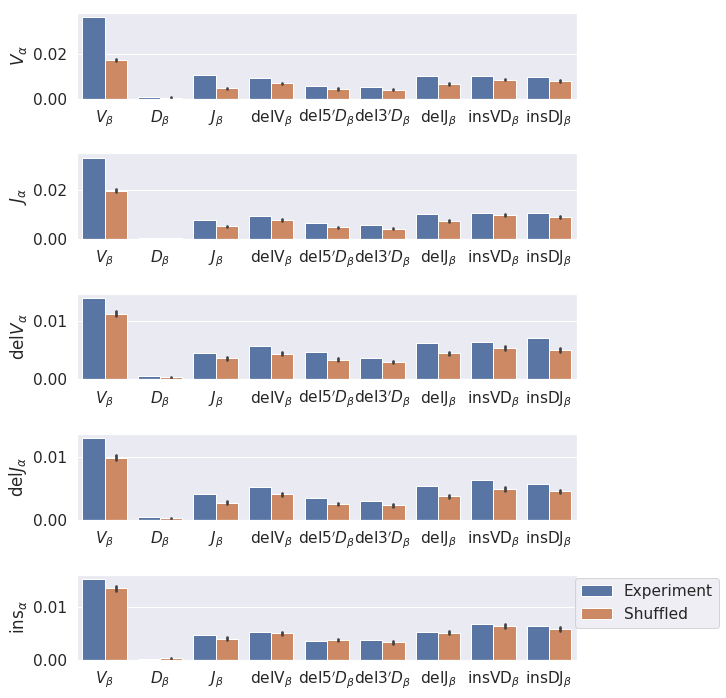

In [18]:
sns.set(font_scale=1.4) 
fig, axes = plt.subplots(5, 1, figsize=(11, 10))

for i, key in enumerate(map_names_a.values()):
    sns.barplot(x="Chrb", y="mi", hue="type", ci="sd",
                data=df_mi[(df_mi.Chra == key)],
                ax=axes[i])
    axes[i].set_xlabel(None)
    axes[i].set_ylabel(key)
    if(i < 4):
        axes[i].get_legend().remove()
        

axes[4].legend(bbox_to_anchor=(1.3, 1.05))

plt.tight_layout()
plt.savefig("alphabeta_mutual_information_error_bar.pdf")
plt.show()

In [25]:
## Compute the pvalues and the fdr

import scipy.stats

# ## Plot the distribution of mutual information, to check if a gaussian test would be ok
# sns.distplot(df_mi[(df_mi.Chra == r'$V_\alpha$') & 
#      (df_mi.Chrb == r'$V_\beta$') & (df_mi.type == "Shuffled")].mi)
# plt.show()

df_mi_exp = df_mi[df_mi.type == "Experiment"].copy()
df_mi_sh = df_mi[df_mi.type == "Shuffled"].copy()
df_mi_sh["mean"] = df_mi_sh.groupby(["Chra", "Chrb"]).mi.transform(np.mean)
df_mi_sh["std"] = df_mi_sh.groupby(["Chra", "Chrb"]).mi.transform(np.std)
df_pv = df_mi_sh.groupby(["Chra", "Chrb"]).apply(np.mean).join(
           df_mi_exp.groupby(["Chra", "Chrb"]).apply(np.mean), how="outer", lsuffix="_sh", rsuffix="_exp")
df_pv["zscore"] = (df_pv.mi_exp - df_pv["mean"])/df_pv["std"]
df_pv["pvalue"] = df_pv.zscore.apply(lambda z: scipy.stats.norm.sf(abs(z))) ## assuming gaussian distribution
fdr = 1e-3
# Benjamini–Hochberg procedure
df_pv = df_pv.sort_values(by="pvalue").copy()
df_pv["pv_rate"] = np.array(range(1, len(df_pv)+1))/len(df_pv)*fdr
df_pv["null_rejected"] = df_pv.pvalue < df_pv.pv_rate
df_pv

mi_sh  nb_sh  \
Chra                   Chrb                                                
$V_\alpha$             $V_\beta$                         0.017275   99.5   
$J_\alpha$             $V_\beta$                         0.019712   99.5   
$V_\alpha$             $J_\beta$                         0.004668   99.5   
                       $\mathrm{delJ}_{\beta}$           0.006566   99.5   
$J_\alpha$             $J_\beta$                         0.005108   99.5   
$V_\alpha$             $\mathrm{delV}_{\beta}$           0.006799   99.5   
$J_\alpha$             $\mathrm{delJ}_{\beta}$           0.007405   99.5   
$\mathrm{del}V_\alpha$ $\mathrm{delJ}_{\beta}$           0.004419   99.5   
                       $\mathrm{insDJ}_{\beta}$          0.004989   99.5   
$\mathrm{del}J_\alpha$ $V_\beta$                         0.009876   99.5   
                       $\mathrm{delJ}_{\beta}$           0.003750   99.5   
$\mathrm{del}V_\alpha$ $V_\beta$                         0.011206   99.5   
                       $\mathrm{del}5^\prime D_{\beta}$  0.003380   99.5   
$J_\alpha$             $\mathrm{delV}_{\beta}$           0.007676   99.5   
$\mathrm{del}J_\alpha$ $J_\beta$                         0.002719   99.5   
                       $\mathrm{insVD}_{\beta}$          0.004863   99.5   
$\mathrm{del}V_\alpha$ $\mathrm{delV}_{\beta}$           0.004369   99.5   
$J_\alpha$             $\mathrm{del}5^\prime D_{\beta}$  0.004753   99.5   
$V_\alpha$             $\mathrm{del}5^\prime D_{\beta}$  0.004268   99.5   
$\mathrm{del}J_\alpha$ $\mathrm{insDJ}_{\beta}$          0.004514   99.5   
$V_\alpha$             $\mathrm{insDJ}_{\beta}$          0.007934   99.5   
$\mathrm{del}J_\alpha$ $\mathrm{delV}_{\beta}$           0.004061   99.5   
$J_\alpha$             $\mathrm{insDJ}_{\beta}$          0.009003   99.5   
$\mathrm{del}J_\alpha$ $\mathrm{del}5^\prime D_{\beta}$  0.002531   99.5   
$J_\alpha$             $\mathrm{del}3^\prime D_{\beta}$  0.004302   99.5   
$V_\alpha$             $\mathrm{del}3^\prime D_{\beta}$  0.003904   99.5   
$\mathrm{del}V_\alpha$ $J_\beta$                         0.003635   99.5   
$V_\alpha$             $\mathrm{insVD}_{\beta}$          0.008556   99.5   
$\mathrm{del}J_\alpha$ $D_\beta$                         0.000236   99.5   
$\mathrm{ins}_\alpha$  $V_\beta$                         0.013560   99.5   
$\mathrm{del}V_\alpha$ $\mathrm{insVD}_{\beta}$          0.005394   99.5   
$\mathrm{del}J_\alpha$ $\mathrm{del}3^\prime D_{\beta}$  0.002274   99.5   
$\mathrm{del}V_\alpha$ $\mathrm{del}3^\prime D_{\beta}$  0.003025   99.5   
$\mathrm{ins}_\alpha$  $J_\beta$                         0.004014   99.5   
$J_\alpha$             $\mathrm{insVD}_{\beta}$          0.009714   99.5   
$\mathrm{del}V_\alpha$ $D_\beta$                         0.000341   99.5   
$\mathrm{ins}_\alpha$  $\mathrm{insDJ}_{\beta}$          0.005854   99.5   
                       $\mathrm{del}3^\prime D_{\beta}$  0.003381   99.5   
                       $\mathrm{insVD}_{\beta}$          0.006345   99.5   
                       $D_\beta$                         0.000375   99.5   
$V_\alpha$             $D_\beta$                         0.000431   99.5   
$\mathrm{ins}_\alpha$  $\mathrm{delJ}_{\beta}$           0.005134   99.5   
$J_\alpha$             $D_\beta$                         0.000475   99.5   
$\mathrm{ins}_\alpha$  $\mathrm{delV}_{\beta}$           0.005095   99.5   
                       $\mathrm{del}5^\prime D_{\beta}$  0.003778   99.5   

                                                             mean       std  \
Chra                   Chrb                                                   
$V_\alpha$             $V_\beta$                         0.017275  0.000557   
$J_\alpha$             $V_\beta$                         0.019712  0.000621   
$V_\alpha$             $J_\beta$                         0.004668  0.000302   
                       $\mathrm{delJ}_{\beta}$           0.006566  0.000336   
$J_\alpha$   

### $\beta$-$\beta$

In [28]:
dfbb = pd.read_csv(filepairsbb, sep="\t")
dfbb = dfbb[dfbb.distance > 15].copy()
base_keys =  ['vname', 'dname', 'jname', 'vdel',
         'jdel','d5del','d3del', 'n2ins', 'n1ins']
keys_1 = [u + "_1" for u in base_keys]
keys_2 = [u + "_2" for u in base_keys]
keys = keys_1 + keys_2
# drop sequences for which VDJ couldn't be inferred
dfbb = dfbb[keys].copy().dropna()

df_beta_1 = dfbb[keys_1].copy()
df_beta_2 = dfbb[keys_2].copy()
Is = mutual_information(dfbb, keys1=keys_1, keys2 = keys_2,
                        return_dict=True)

df_mi_raw = pd.Series(Is).reset_index()
df_mi_raw.columns = ["Chr1", "Chr2", "mi"]
df_mi_raw["type"] = "Experiment"
df_mi_raw["nb"] = -1

df_mi = df_mi_raw.copy()

for i in range(20):
    df_beta_1.reset_index(drop=True, inplace=True)
    df_beta_2.reset_index(drop=True, inplace=True)
    df_beta_1 = df_beta_1.sample(frac=1).reset_index(drop=True)
    Is_shuff= mutual_information(
        pd.concat([df_beta_1, df_beta_2], axis=1),
                                        keys1=keys_1, keys2=keys_2, return_dict=True)
    df_mi_sh = pd.Series(Is_shuff).reset_index()
    df_mi_sh.columns = ["Chr1", "Chr2", "mi"]
    df_mi_sh["type"] = "Shuffled"
    df_mi_sh["nb"] = i
    df_mi = pd.concat((df_mi, df_mi_sh))

map_names = {'vname':r'$V_\beta$', 'dname':r'$D_\beta$',
             'jname':r'$J_\beta$',
             'vdel':r'$\mathrm{delV}_{\beta}$',
             'jdel':r'$\mathrm{delJ}_{\beta}$', 
             'd5del': r'$\mathrm{del}5^\prime D_{\beta}$', 
             'd3del': r'$\mathrm{del}3^\prime D_{\beta}$',
             'n2ins': r'$\mathrm{insVD}_{\beta}$',
             'n1ins': r'$\mathrm{insDJ}_{\beta}$'}

df_mi["Chr1"] = df_mi.Chr1.apply(lambda x: map_names[x[:-2]])
df_mi["Chr2"] = df_mi.Chr2.apply(lambda x: map_names[x[:-2]])

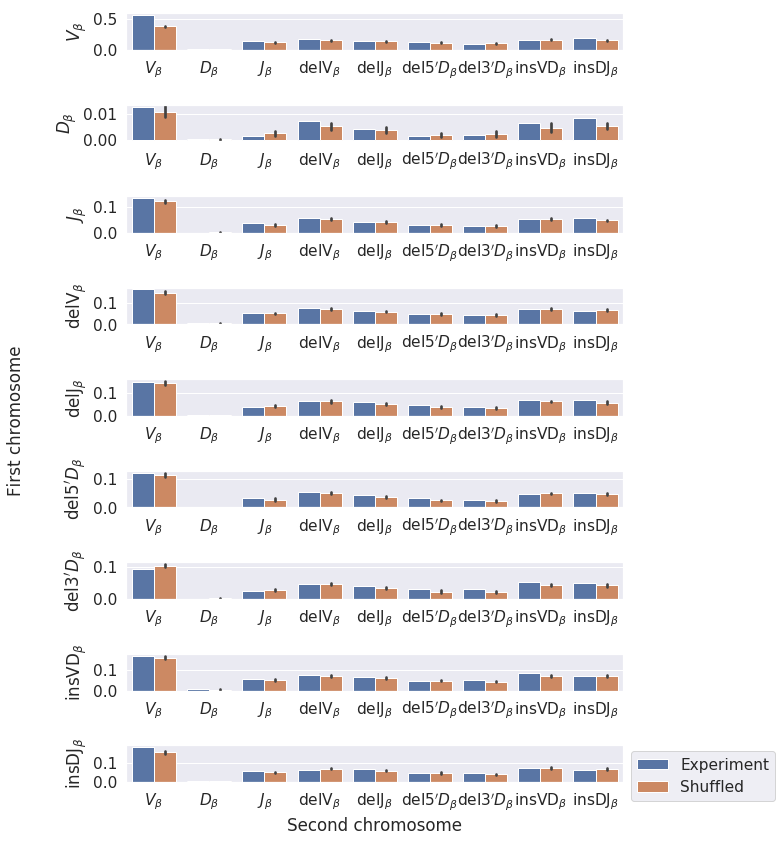

In [29]:
sns.set(font_scale=1.4) 
fig, axes = plt.subplots(9, 1, figsize=(10.5, 12))

for i, key in enumerate(map_names.values()):
    sns.barplot(x="Chr2", y="mi", hue="type", ci="sd",
                data=df_mi[(df_mi.Chr1 == key)],
                ax=axes[i])
    axes[i].set_xlabel(None)
    axes[i].set_ylabel(key)
    if i < 8:
        axes[i].get_legend().remove()

axes[8].legend(bbox_to_anchor=(1., 1.05))
fig.text(-0.04, 0.5, "First chromosome", va='center', rotation='vertical')
axes[8].set_xlabel("Second chromosome")
plt.tight_layout()
fig.savefig("betabeta_mutual_information_error_bar.pdf")
plt.show()

In [30]:
import scipy.stats

# ## Plot the distribution of mutual information, to check if a gaussian test would be of
# sns.distplot(df_mi[(df_mi.Chr1 == r'$V_\beta$') & 
#      (df_mi.Chr2 == r'$V_\beta$') & (df_mi.type == "Shuffled")].mi)
# plt.show()

df_mi_exp = df_mi[df_mi.type == "Experiment"].copy()
df_mi_sh = df_mi[df_mi.type == "Shuffled"].copy()
df_mi_sh["mean"] = df_mi_sh.groupby(["Chr1", "Chr2"]).mi.transform(np.mean)
df_mi_sh["std"] = df_mi_sh.groupby(["Chr1", "Chr2"]).mi.transform(np.std)
df_pv = df_mi_sh.groupby(["Chr1", "Chr2"]).apply(np.mean).join(
           df_mi_exp.groupby(["Chr1", "Chr2"]).apply(np.mean), how="outer", lsuffix="_sh", rsuffix="_exp")
df_pv["zscore"] = (df_pv.mi_exp - df_pv["mean"])/df_pv["std"]
df_pv["pvalue"] = df_pv.zscore.apply(lambda z: scipy.stats.norm.sf(abs(z))) ## assuming gaussian distribution
fdr = 1e-2
# Benjamini–Hochberg procedure
df_pv = df_pv.sort_values(by="pvalue").copy()
df_pv["pv_rate"] = np.array(range(1, len(df_pv)+1))/len(df_pv)*fdr
df_pv["null_rejected"] = df_pv.pvalue < df_pv.pv_rate
df_pv

mi_sh  \
Chr1                             Chr2                                         
$V_\beta$                        $V_\beta$                         0.376305   
                                 $\mathrm{insDJ}_{\beta}$          0.154354   
$\mathrm{del}5^\prime D_{\beta}$ $\mathrm{del}5^\prime D_{\beta}$  0.024484   
$\mathrm{insDJ}_{\beta}$         $V_\beta$                         0.152416   
$\mathrm{insVD}_{\beta}$         $\mathrm{del}3^\prime D_{\beta}$  0.044098   
$V_\beta$                        $\mathrm{delV}_{\beta}$           0.150205   
$D_\beta$                        $\mathrm{insDJ}_{\beta}$          0.005410   
$\mathrm{del}3^\prime D_{\beta}$ $\mathrm{del}3^\prime D_{\beta}$  0.021946   
                                 $\mathrm{insVD}_{\beta}$          0.043746   
$\mathrm{insVD}_{\beta}$         $\mathrm{insVD}_{\beta}$          0.072538   
$J_\beta$                        $\mathrm{insDJ}_{\beta}$          0.047872   
$\mathrm{delV}_{\beta}$          $V_\beta$                         0.149817   
$\mathrm{del}3^\prime D_{\beta}$ $V_\beta$                         0.102702   
$\mathrm{insVD}_{\beta}$         $D_\beta$                         0.004781   
$\mathrm{insDJ}_{\beta}$         $\mathrm{delJ}_{\beta}$           0.057966   
                                 $\mathrm{del}3^\prime D_{\beta}$  0.040041   
$J_\beta$                        $V_\beta$                         0.121856   
$\mathrm{del}5^\prime D_{\beta}$ $\mathrm{delJ}_{\beta}$           0.037372   
$\mathrm{delJ}_{\beta}$          $\mathrm{insVD}_{\beta}$          0.062422   
$\mathrm{del}3^\prime D_{\beta}$ $\mathrm{delJ}_{\beta}$           0.034546   
                                 $\mathrm{del}5^\prime D_{\beta}$  0.023080   
$\mathrm{del}5^\prime D_{\beta}$ $\mathrm{insDJ}_{\beta}$          0.045328   
$\mathrm{insVD}_{\beta}$         $V_\beta$                         0.161837   
$\mathrm{delV}_{\beta}$          $\mathrm{delV}_{\beta}$           0.071641   
$V_\beta$                        $J_\beta$                         0.120778   
$\mathrm{delJ}_{\beta}$          $\mathrm{del}3^\prime D_{\beta}$  0.034371   
                                 $J_\beta$                         0.042569   
                                 $\mathrm{del}5^\prime D_{\beta}$  0.039899   
                                 $\mathrm{insDJ}_{\beta}$          0.057615   
$\mathrm{insDJ}_{\beta}$         $J_\beta$                         0.050321   
...                                                                     ...   
$D_\beta$                        $V_\beta$                         0.011010   
$J_\beta$                        $D_\beta$                         0.002658   
$\mathrm{del}5^\prime D_{\beta}$ $\mathrm{delV}_{\beta}$           0.050174   
$\mathrm{insDJ}_{\beta}$         $D_\beta$                         0.005837   
$D_\beta$                        $\mathrm{del}5^\prime D_{\beta}$  0.001819   
$\mathrm{insVD}_{\beta}$         $\mathrm{del}5^\prime D_{\beta}$  0.049243   
                                 $\mathrm{delV}_{\beta}$           0.072031   
$J_\beta$                        $\mathrm{insVD}_{\beta}$          0.052574   
$\mathrm{del}3^\prime D_{\beta}$ $D_\beta$                         0.001872   
$\mathrm{delV}_{\beta}$          $\mathrm{del}3^\prime D_{\beta}$  0.044281   
$\mathrm{delJ}_{\beta}$          $\mathrm{delV}_{\beta}$           0.062039   
$\mathrm{insDJ}_{\beta}$         $\mathrm{del}5^\prime D_{\beta}$  0.046003   
$\mathrm{del}5^\prime D_{\beta}$ $D_\beta$                         0.002312   
$\mathrm{insDJ}_{\beta}$         $\mathrm{insDJ}_{\beta}$          0.065259   
$\mathrm{delV}_{\beta}$          $D_\beta$                         0.005666   
$V_\beta$                        $\mathrm{delJ}_{\beta}$           0.140339   
$\mathrm{delJ}_{\beta}$          $V_\beta$                         0.141387   
$D_\beta$                        $\mathrm{del}3^\prime D_{\beta}$  0.002231   
$\mathrm{del}3^\prime D_{\beta}$ $\mathrm